In [1]:
import numpy as np
import pandas as pd
from time import time

# import pytorch and set dgl backend to pytorch
import os
os.environ['DGLBACKEND'] = 'pytorch'
import torch
import torch.nn  as nn
import torch.nn.functional as F

try:
    import dgl
except ModuleNotFoundError:
    !pip install dgl
    import dgl

import networkx as nx
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 64.5 MB/s eta 0:00:00


In [2]:
transactions_df = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
num_transactions = transactions_df.shape[0]
print("Number of transactions: ", num_transactions)
print(f"Proportion of fraudulent transaction: {transactions_df.isFraud.value_counts(normalize=True)[1]:.4f}")
identity_df = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
print("Number of transaction with ID data: ",identity_df.shape[0])
print('-'*40)
print("Dataframe head:")
display(transactions_df.head())
display(identity_df.head())

Number of transactions:  590540
Proportion of fraudulent transaction: 0.0350
Number of transaction with ID data:  144233
----------------------------------------
Dataframe head:


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [3]:
# user set the ratio
TRAIN_VAL_RATIO = 0.75

# determine number of training records
n_train = int(transactions_df.shape[0]*TRAIN_VAL_RATIO)

# train/val split : split by time, training set preceeds val set.
train_ids = transactions_df.TransactionID[:n_train]
val_ids = transactions_df.TransactionID[n_train:]

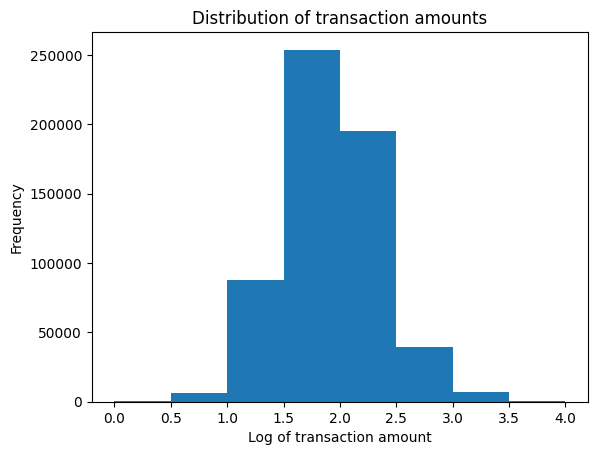

In [4]:
# get id columns from transactions_df
id_cols = ['card1','card2','card3','card4','card5','card6','ProductCD','addr1','addr2','P_emaildomain','R_emaildomain'] 
# get categorical columns for node features
cat_cols = ['M1','M2','M3','M4','M5','M6','M7','M8','M9']   
# get features and labels
transactions_non_features = ['isFraud','TransactionDT'] + id_cols
features_cols = [col for col in transactions_df.columns if col not in transactions_non_features]
# create df for transaction node features
features_df = pd.get_dummies(transactions_df[features_cols], columns=cat_cols).fillna(0)
# take log of transaction amount
features_df['TransactionAmt'] = features_df['TransactionAmt'].apply(np.log10)
# show new distribution
features_df['TransactionAmt'].plot(kind='hist', bins=[0,0.5,1,1.5,2,2.5,3,3.5,4])
plt.title('Distribution of transaction amounts')
plt.xlabel('Log of transaction amount')
plt.show()
# create a df for the labels
labels_df = transactions_df[['TransactionID','isFraud']]
# create a list of all node types except TransactionID
node_types = id_cols + list(identity_df.columns)
node_types.remove('TransactionID')
# join the dfs to get a table with all ID data
full_identity_df = identity_df.merge(transactions_df[id_cols+['TransactionID']], on='TransactionID', how='right')
# create a dictionary of df that will determine the edges in the graph
edge_dfs = {}
for ntype  in node_types:
    edge_dfs[ntype] = full_identity_df[['TransactionID', ntype]].dropna() 

In [5]:
# initialize the dictionary to store each ID to dgl node index dictionary
id_to_node = {}

# First get dgl indices for TransactionID/target nodes
id_to_node['target'] = dict([(v,k) for k,v in dict(transactions_df['TransactionID']).items()])

# Then cycle through the other ID types and add those to the list (dict)
for ntype in node_types:
    new_nodes_ids = edge_dfs[ntype][ntype].unique()
    new_nodes_dgl = np.arange(len(new_nodes_ids)+1)
    id_to_node[ntype] = { a:b for a,b in zip(new_nodes_ids, new_nodes_dgl)}

In [6]:
# for example:
id_to_node['card4']

{'discover': 0, 'mastercard': 1, 'visa': 2, 'american express': 3}

In [7]:
# instantiate the edge list dictionary
edgelists = {}
num_nodes_dict = {}

for ntype in node_types:
    # prepare each edge type triple and its reverse
    edge_type = ('target','target<>'+ntype,ntype)
    rev_edge_type = (ntype, ntype+'<>target','target')
    # get list of initial nodes and destination nodes
    source_nodes = edge_dfs[ntype]['TransactionID'].apply(lambda a : id_to_node['target'][a]).to_numpy()
    destination_nodes = edge_dfs[ntype][ntype].apply(lambda a : id_to_node[ntype][a]).to_numpy()
    # add to dict
    edgelists[edge_type] = ( source_nodes, destination_nodes )
    edgelists[rev_edge_type] = (destination_nodes, source_nodes)
    # get number of nodes of this type
    num_nodes_dict[ntype] = len(np.unique(destination_nodes))
    
# add self-loops for target nodes
source_nodes = edge_dfs[ntype]['TransactionID'].apply(lambda a : id_to_node['target'][a]).to_numpy()
edgelists[('target','target<>target','target')] = (source_nodes,source_nodes)
num_nodes_dict['target'] = num_transactions

In [8]:
# create the graph
g = dgl.heterograph(edgelists, num_nodes_dict)

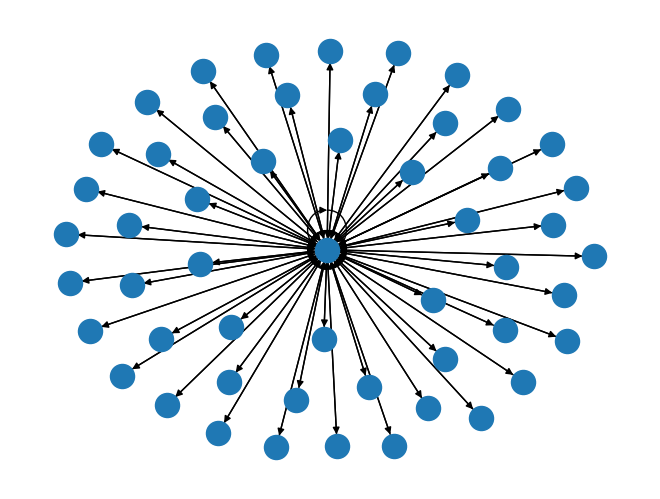

In [9]:
# Visualizing the metagraph (sanity check: it should be star-shaped, with the target node in the center and a node for each id feature)
meta = g.metagraph()
nx.draw(meta)

In [10]:
features_df.head()

,TransactionID,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,...,M5_F,M5_T,M6_F,M6_T,M7_F,M7_T,M8_F,M8_T,M9_F,M9_T
0,2987000,1.835691,19.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,True,False,False,True,False,False,False,False,False,False
1,2987001,1.462398,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,False,True,False,True,False,False,False,False,False,False
2,2987002,1.770852,287.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,True,False,True,False,True,False,True,False,True,False
3,2987003,1.698970,0.0,0.0,2.0,5.0,0.0,0.0,0.0,4.0,...,False,True,True,False,False,False,False,False,False,False
4,2987004,1.698970,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,False,False,False,False,False


In [11]:
features = features_df.drop('TransactionID', axis=1)
feature_array = features.to_numpy(dtype=np.float32)
# Convert numpy array to PyTorch tensor
feature_tensor = torch.from_numpy(feature_array)

In [12]:

# add feature data to graph
g.nodes['target'].data['features'] = feature_tensor

In [13]:
# sanity check
# for random target node, compare expected features with the feature of the node
trial = 1515

orig_feat_np = features_df.iloc[trial, 1:].to_numpy(dtype=np.float32)
orig_feat = torch.from_numpy(orig_feat_np)

# data from the graph
graph_feat = g.ndata['features']['target'][trial]

assert max(orig_feat - graph_feat) == 0
print('Feature vectors match. Check is good!')

Feature vectors match. Check is good!


In [14]:
train_mask = [ id_to_node['target'][x] for x in train_ids]
val_mask = [ id_to_node['target'][x] for x in val_ids]

In [15]:
labels = torch.tensor(labels_df['isFraud'].to_numpy()).float()

In [16]:
mean = torch.mean(g.ndata['features']['target'], axis=0)
std = torch.sqrt(torch.sum((g.ndata['features']['target'] - mean)**2, axis=0)/g.ndata['features']['target'].shape[0])

In [17]:
g.ndata['features']['target'] = (g.ndata['features']['target'] - mean)/std

In [18]:
# Conv layers
INPUT_DIM = 8
HIDDEN_DIM = 8
TARGET_OUT_DIM = 8
CONV_LAYERS = 2 # should be at least 2; only have 3 'distinct' layers, weights for the middle ones are shared with all layers except first and last.
# pre/post processing of target
TARGET_PREPROCESSING_HIDDEN_DIM = 32
TARGET_PREPROCESSING_NO_LAYERS = 3
TARGET_POSTPROCESSING_HIDDEN_DIM = 8
TARGET_POSTPROCESSING_NO_LAYERS = 2
# training
LEARNING_RATE = 0.001
LOSS_MULTIPLIER = 15
NUM_EPOCHS = 70

In [19]:
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import HeteroGraphConv, HeteroEmbedding, GraphConv
from torch.nn import Linear

# Assuming 'g' and 'node_types' are defined elsewhere in your code

# get dimension of target features
target_feature_dim = g.ndata['features']['target'].shape[1]

# create linear embeddings for the non-target nodes into R^IN_DIM space
num_embeddings_dict = {src: g.num_nodes(src) for (src, etype, dst) in g.canonical_etypes if (dst == 'target' and src != 'target')}

# define a NN for pre/postprocessing the target data
class ff_block(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, n_layers):
        super().__init__()
        self.input_layer = Linear(in_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList([Linear(hidden_dim, hidden_dim) for _ in range(n_layers - 1)])
        self.output_layer = Linear(hidden_dim, out_dim)
        
    def forward(self, in_feats):
        h = self.input_layer(in_feats)
        h = F.relu(h)
        for layer in self.hidden_layers:
            h = layer(h)
            h = F.relu(h)
        h = self.output_layer(h)
        return h

# define the model class
class RGCN(nn.Module):
    def __init__(self, target_feature_dim, in_dim, hidden_dim, conv_out_dim, num_conv_layers, num_embeddings, target_pre_h_dim, target_pre_layers, target_post_h_dim, target_post_layers):
        super().__init__()
        
        entry_module_dict = {etype: GraphConv(in_feats=in_dim, out_feats=hidden_dim) for etype in g.etypes}
        hidden_model_dict = {etype: GraphConv(in_feats=hidden_dim, out_feats=hidden_dim) for etype in g.etypes}
        
        final_model_dict1 = {etype: GraphConv(in_feats=hidden_dim, out_feats=conv_out_dim) for src, etype, dst in g.canonical_etypes if dst == 'target'}
        final_model_dict2 = {etype: GraphConv(in_feats=hidden_dim, out_feats=1) for src, etype, dst in g.canonical_etypes if dst != 'target'}
        final_model_dict = {**final_model_dict1, **final_model_dict2}
        
        self.num_conv_layers = num_conv_layers
        
        self.embed_layer = HeteroEmbedding(num_embeddings, in_dim)
        
        self.target_preprocessing = ff_block(target_feature_dim, target_pre_h_dim, in_dim, target_pre_layers)
        
        self.conv1 = HeteroGraphConv(entry_module_dict, aggregate='sum')
        self.conv2 = HeteroGraphConv(hidden_model_dict, aggregate='sum')
        self.conv3 = HeteroGraphConv(final_model_dict, aggregate='sum')
        
        self.target_postprocessing = ff_block(conv_out_dim, target_post_h_dim, 1, target_post_layers)
        
    def forward(self, graph, input_features):
        embeds = self.embed_layer({ntype: graph.nodes(ntype) for ntype in node_types})
        input_features = input_features.to(dtype=torch.float32)
        target_features = self.target_preprocessing(input_features)
        embeds['target'] = target_features
        
        h = self.conv1(graph, embeds)
        h = {k: F.relu(v) for k, v in h.items()}
        
        for i in range(2, self.num_conv_layers):
            h = self.conv2(graph, h)
            h = {k: F.relu(v) for k, v in h.items()}
        
        h = self.conv3(graph, h)
        h['target'] = self.target_postprocessing(h['target'])
        
        return h


In [20]:
# create the model
model = RGCN(
    target_feature_dim = target_feature_dim,
    in_dim = INPUT_DIM, 
    hidden_dim = HIDDEN_DIM, 
    conv_out_dim = TARGET_OUT_DIM,
    num_conv_layers = CONV_LAYERS,
    num_embeddings = num_embeddings_dict, 
    target_pre_h_dim = TARGET_PREPROCESSING_HIDDEN_DIM, 
    target_pre_layers = TARGET_PREPROCESSING_NO_LAYERS,
    target_post_h_dim = TARGET_POSTPROCESSING_HIDDEN_DIM,
    target_post_layers = TARGET_POSTPROCESSING_NO_LAYERS
)
print('Number of parameters in the model: ')
print(' '*33,sum(param.numel() for param in model.parameters()))

Number of parameters in the model: 
                                  1120516


In [21]:
# prepare weight vector for loss fn
weight_vector = (torch.ones(labels[train_mask].shape)+labels[train_mask]*LOSS_MULTIPLIER).reshape((labels[train_mask].shape[0],1))
val_weight_vector = (torch.ones(labels[val_mask].shape)+labels[val_mask]*LOSS_MULTIPLIER).reshape((labels[val_mask].shape[0],1))

# Set optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.BCELoss(weight_vector)
val_loss_fn = torch.nn.BCELoss(val_weight_vector)

In [22]:
def train_one_epoch(epoch_no, model, g, features, labels, train_mask, val_mask, threshold, return_probs=False):
    t0 = time()
    # Forward pass
    logits_dict = model(g, features)
    logits = logits_dict['target']
    del logits_dict
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
       
    labels = labels.reshape_as(preds)
    
    # compute training and validation loss
    loss = loss_fn(probs[train_mask], labels[train_mask])
    with torch.no_grad():
        val_loss = val_loss_fn(probs[val_mask], labels[val_mask])
        # compute accuracies
    train_acc = (preds[train_mask] == labels[train_mask]).float().mean()
    val_acc = (preds[val_mask] == labels[val_mask]).float().mean()
    
    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if return_probs:
        return loss, val_loss, train_acc, val_acc, time()-t0, probs, preds
    else:
        return loss, val_loss, train_acc, val_acc, time()-t0

In [23]:
# function for visualizing loss history
def loss_history_plot(loss_history, val_loss_history=None, small=False):
    if small:
        size = (5,2)
    else:
        size = (7,4)
    fig, ax =plt.subplots(1,1,figsize=size)
    ax.plot(loss_history, label='Train')
    if val_loss_history:
        ax.plot(val_loss_history, label='Val')
        ax.legend()
    plt.show()

In [24]:
def train(model, g, num_epochs, labels, train_mask, val_mask, threshold):
    best_val_acc = 0
    epoch_times = []
    history = {}
    history['loss'] = []
    history['val_loss'] = []
    history['val_acc'] = []
    
    features = g.nodes['target'].data['features']
    
    for epoch in range(num_epochs):
        
        if epoch < num_epochs-1:
            loss, val_loss, train_acc, val_acc, epoch_time = train_one_epoch(epoch, model, g, features, labels, train_mask, val_mask, threshold)
        else:
            loss, val_loss, train_acc, val_acc, epoch_time, final_probs, final_preds = train_one_epoch(epoch, model, g, features, labels, train_mask, val_mask, threshold, return_probs=True)
            
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['loss'].append(loss.detach().numpy())
        epoch_times.append(epoch_time)
        
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            
        if epoch % 10 == 10-1:
            loss_rate_of_change = (history['loss'][-1]-history['loss'][-5])/5
            print(f"Epoch {epoch+1} loss: {loss:.3f}, (rate of change: {loss_rate_of_change:.4f}), val accuracy: {val_acc:.3f} (best: {best_val_acc:.3f})\n\
            -- Average time per epoch: {np.mean(epoch_times):.1f}sec (last 5: {np.mean(epoch_times[-5:]):.1f}sec).\
            Estimated time to end: {(num_epochs-epoch-1)*np.mean(epoch_times[-5:])/60:.0f} mins")
            
        if epoch % 25 == 25-1:
            loss_history_plot(history['loss'][-25:], history['val_loss'][-25:], small=True)
            loss_history_plot(history['val_acc'][-25:], small=True)
            
    print('-'*60)
    print(f"Training complete. \
    Final loss: {loss:.3f}, \
    final val accuracy: {val_acc:.3f}, (best: {best_val_acc:.3f}).")
    
    return final_probs, final_preds, history

Epoch 10 loss: 1.959, (rate of change: -0.2658), val accuracy: 0.894 (best: 0.946)
            -- Average time per epoch: 7.9sec (last 5: 6.5sec).            Estimated time to end: 6 mins
Epoch 20 loss: 1.119, (rate of change: -0.0261), val accuracy: 0.902 (best: 0.946)
            -- Average time per epoch: 7.2sec (last 5: 6.5sec).            Estimated time to end: 5 mins


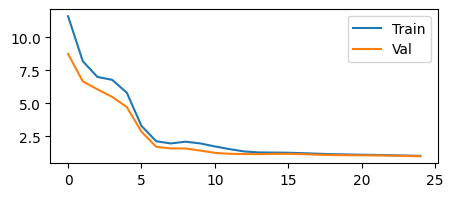

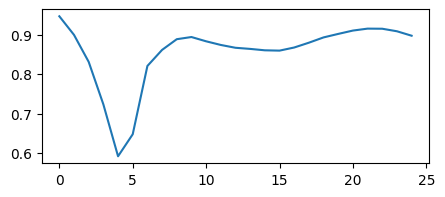

Epoch 30 loss: 0.966, (rate of change: -0.0041), val accuracy: 0.864 (best: 0.946)
            -- Average time per epoch: 7.0sec (last 5: 6.5sec).            Estimated time to end: 4 mins
Epoch 40 loss: 0.913, (rate of change: -0.0028), val accuracy: 0.901 (best: 0.946)
            -- Average time per epoch: 6.9sec (last 5: 6.5sec).            Estimated time to end: 3 mins
Epoch 50 loss: 0.894, (rate of change: -0.0011), val accuracy: 0.898 (best: 0.946)
            -- Average time per epoch: 6.8sec (last 5: 6.6sec).            Estimated time to end: 2 mins


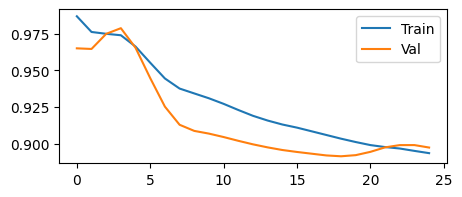

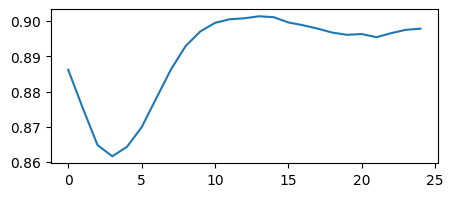

Epoch 60 loss: 0.881, (rate of change: -0.0009), val accuracy: 0.888 (best: 0.946)
            -- Average time per epoch: 6.8sec (last 5: 6.5sec).            Estimated time to end: 1 mins
Epoch 70 loss: 0.870, (rate of change: -0.0007), val accuracy: 0.875 (best: 0.946)
            -- Average time per epoch: 6.7sec (last 5: 6.5sec).            Estimated time to end: 0 mins
------------------------------------------------------------
Training complete.     Final loss: 0.870,     final val accuracy: 0.875, (best: 0.946).


In [25]:
QUICK_TEST = False

if QUICK_TEST:
    n_ep = 2
else:
    n_ep = NUM_EPOCHS

probs, preds, history = train(model, g, n_ep, labels, train_mask, val_mask, 0.5)

In [26]:
print('Evaluation of validation set results:\n','-'*50)

print(f"Proportion of transactions predicted as fraud: {torch.mean(preds[val_mask])*100:.2f} %.")
cm = confusion_matrix(preds[val_mask], labels[val_mask])
print(cm)
fp_rate = cm[1,0]/(cm[1,0]+cm[1,1])
print(f"False positive rate: {fp_rate*100:.1f} %.")
fn_rate = cm[0,1]/(cm[0,1]+cm[0,0])
print(f"False negative rate: {fn_rate*100:.2f} %.")
tn_rate = 1-fp_rate
print(f"True negative rate: {tn_rate*100:.2f} % (specificity).")
tp_rate = 1- fn_rate
print(f"True positive rate: {tp_rate*100:.2f} % (sensitivity).")

Evaluation of validation set results:
 --------------------------------------------------
Proportion of transactions predicted as fraud: 12.12 %.
[[126912   2834]
 [ 15623   2266]]
False positive rate: 87.3 %.
False negative rate: 2.18 %.
True negative rate: 12.67 % (specificity).
True positive rate: 97.82 % (sensitivity).


In [27]:
# Calculate Precision
precision = tp_rate / (tp_rate + fp_rate)

# Calculate Recall (Sensitivity)
recall = tp_rate / (tp_rate + fn_rate)

# Calculate F1 Score
f1 = 2 * (precision * recall) / (precision + recall)

# Print results
print(f"Precision: {precision*100:.2f} %")
print(f"Recall (Sensitivity): {recall*100:.2f} %")
print(f"F1 Score: {f1*100:.2f} %")

Precision: 52.83 %
Recall (Sensitivity): 97.82 %
F1 Score: 68.61 %


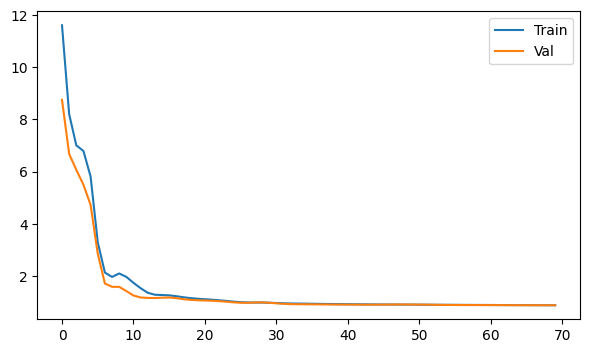

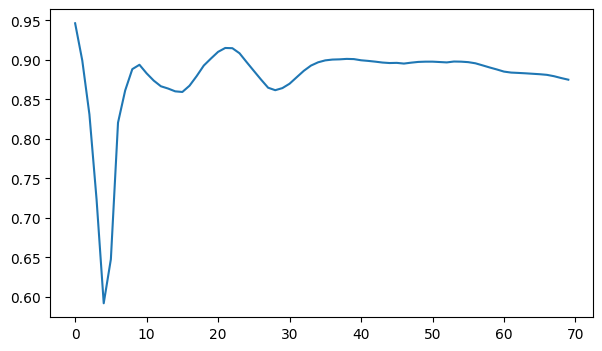

In [28]:
loss_history_plot(history['loss'], history['val_loss'])
loss_history_plot(history['val_acc'])